In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
import nltk

from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from time import time  
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
nltk.download('popular')
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/mirko/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/mirko/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/mirko/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/mirko/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/mirko/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/mirko/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

In [3]:
dataset = pd.read_csv('bbc_data.csv')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

clean_dataset = pd.DataFrame(dataset.news_article.apply(lambda x: clean_text(x)))
clean_dataset.head()

,news_article
0,claxton hunting first major medal british hurd...
1,osullivan could run worlds sonia osullivan ind...
2,greene sets sights world title maurice greene ...
3,iaaf launches fight drugs iaaf athletics world...
4,dibaba breaks world record ethiopias tirunesh ...


In [4]:
nlp = spacy.load('en', disable=['ner', 'parser']) 

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

clean_dataset["text_lemmatize"] =  clean_dataset.apply(lambda x: lemmatizer(x['news_article']), axis=1)
clean_dataset.head()

,news_article,text_lemmatize
0,claxton hunting first major medal british hurd...,claxton hunting first major medal british hurd...
1,osullivan could run worlds sonia osullivan ind...,osullivan could run world sonia osullivan indi...
2,greene sets sights world title maurice greene ...,greene set sights world title maurice greene a...
3,iaaf launches fight drugs iaaf athletics world...,iaaf launch fight drug iaaf athletic world gov...
4,dibaba breaks world record ethiopias tirunesh ...,dibaba break world record ethiopias tirunesh d...


In [5]:
clean_dataset['text_lemmatize_clean'] = clean_dataset['text_lemmatize'].str.replace('-PRON-', '')

In [6]:
sentences = [row.split() for row in clean_dataset['text_lemmatize_clean']]
word_freq = defaultdict(int)

for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
len(word_freq)

26752

In [7]:
w2v_model = Word2Vec(min_count=200, window=5, size=100, workers=4)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
w2v_model.wv.most_similar(positive=['people'])

[('let', 0.9629104137420654),
 ('able', 0.9334889054298401),
 ('way', 0.9267094731330872),
 ('different', 0.921619176864624),
 ('work', 0.9097321033477783),
 ('create', 0.9047125577926636),
 ('mean', 0.8891158103942871),
 ('important', 0.8814709782600403),
 ('hard', 0.8732551336288452),
 ('many', 0.8716675043106079)]

In [9]:
w2v_model.wv.most_similar(positive=['different'])

[('let', 0.9606335163116455),
 ('create', 0.9487866163253784),
 ('way', 0.9400123357772827),
 ('people', 0.921619176864624),
 ('work', 0.9152036309242249),
 ('able', 0.8994904160499573),
 ('important', 0.8908841609954834),
 ('age', 0.8906151652336121),
 ('make', 0.8889712691307068),
 ('like', 0.8842229843139648)]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


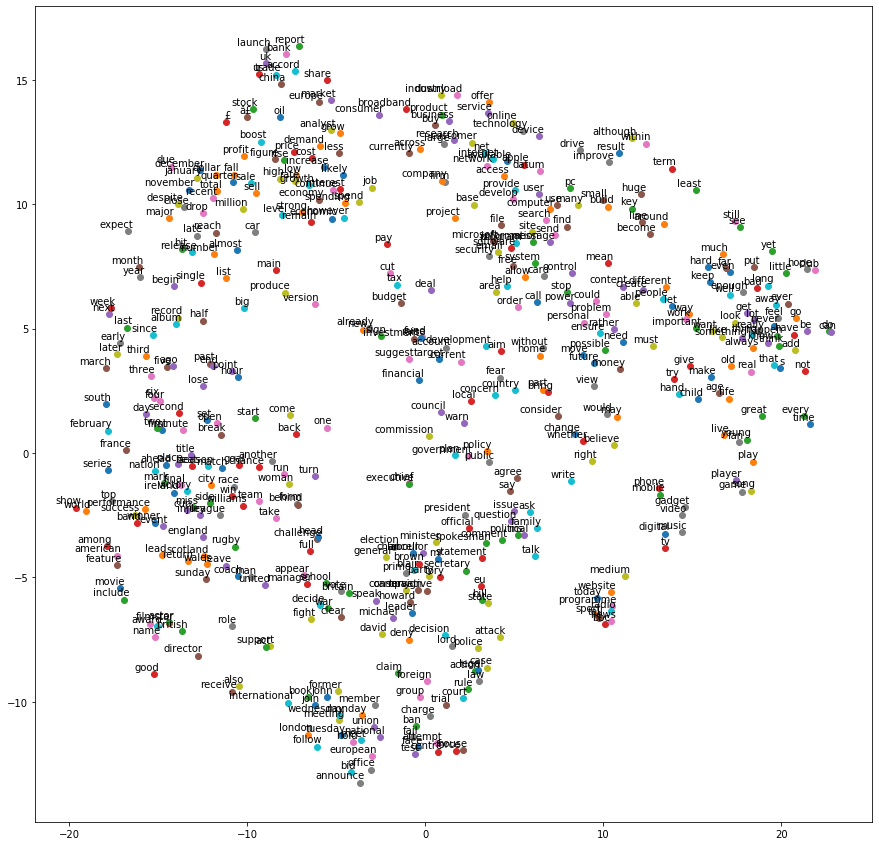

In [10]:
labels = []
tokens = []

for word in w2v_model.wv.vocab:
    tokens.append(w2v_model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(15, 15)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    
plt.show()